# Import Libraries

In [1]:
import os
import random

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import torch

import torch.nn as nn

from torch.utils.data import DataLoader

from torchvision import transforms,datasets

from torchvision.utils import make_grid

In [5]:
from PIL import Image

# CUDA check

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

# CNN in PyTorch

In [8]:
DATA_PATH = r"C:\Users\User\Desktop\DSA\Week_11_Python_Day_1\homework\data_framework_full"

## Normalize and preprocess data

In [10]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
batch_size = 32

In [12]:
train_dataset = datasets.ImageFolder(root=DATA_PATH + '\seg_train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
test_dataset = datasets.ImageFolder(root=DATA_PATH + '\seg_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a random train image

In [14]:
def show_image(dataset,index):

    # Extract the image and its corresponding label
    image,label = dataset[index]

    image = (image+1)/2

    image = image.numpy().transpose((1, 2, 0))

    # Plot the image using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

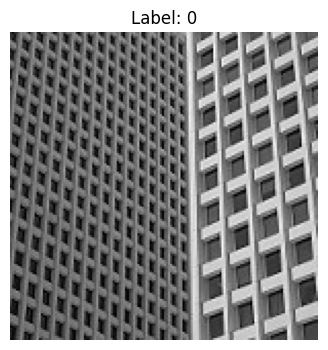

In [15]:
show_image(train_dataset,41)

## Visualize a batch of training data

In [16]:
def show_batch(loader,ncols=4):

    for images,labels in loader:
        break

    images = (images+1)/2
    
    fig, axis = plt.subplots(figsize=(12, 12))
    
    axis.axis('off')
    
    axis.imshow(make_grid(images, nrow=ncols).permute(1, 2, 0))

    plt.show()

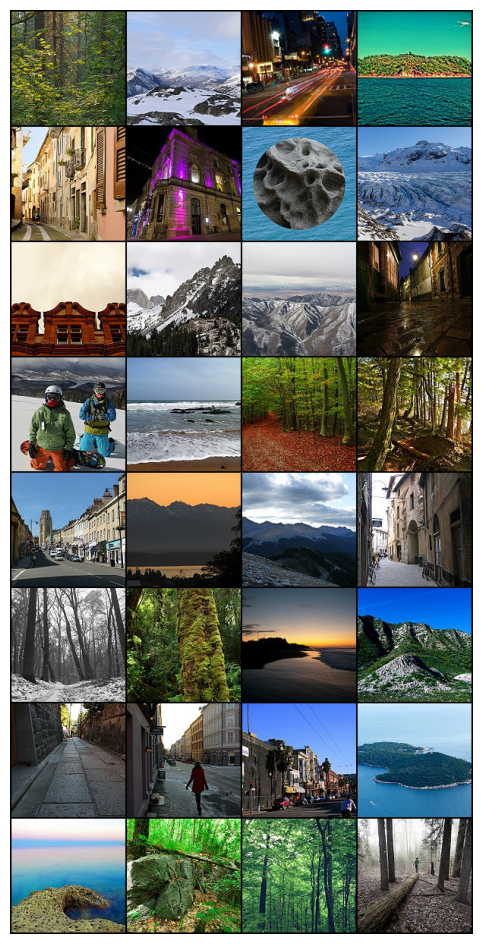

In [17]:
show_batch(train_loader)

## Model Class

In [18]:
class CNN(nn.Module):
    """Convolutional neural network with two convolutional layers"""
    
    def __init__(self,num_classes):
        
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),    # output = (32 - 3 + 2*1)1 + 1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                   # output = (32 - 2)/2+1 = 16
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   # output = (64 - 3 + 2*1)1 + 1 = 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                   # output = (16 - 2)/2+1 = 8
        
        self.drop_out = nn.Dropout()
        
        self.fc1 = nn.Linear(64 * 37 * 37, 128) # 64 * 37 * 37
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0),-1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [19]:
num_classes = 6

In [20]:
model = CNN(num_classes).to(device)

## Loss Function and Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
learning_rate = 0.001

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model Training

In [24]:
num_epochs = 10

In [26]:
total_step = len(train_loader)

for j,epoch in enumerate(range(num_epochs)):

    loss_list,acc_list = [],[]
    
    for i, data in enumerate(train_loader):

        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and perform Adam optimisation
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        loss_list.append(loss.item())
        acc_list.append(correct/total)

    losmean = np.array(loss_list).mean()
    accmean = np.array(acc_list).mean()*100

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losmean:.4f}, Accuracy: {accmean:.2f}%')

Epoch [1/10], Loss: 1.1005, Accuracy: 60.82%
Epoch [2/10], Loss: 0.6624, Accuracy: 75.89%
Epoch [3/10], Loss: 0.5527, Accuracy: 79.86%
Epoch [4/10], Loss: 0.4784, Accuracy: 83.01%
Epoch [5/10], Loss: 0.4296, Accuracy: 84.77%
Epoch [6/10], Loss: 0.3905, Accuracy: 85.76%
Epoch [7/10], Loss: 0.3411, Accuracy: 87.39%
Epoch [8/10], Loss: 0.3078, Accuracy: 88.54%
Epoch [9/10], Loss: 0.2669, Accuracy: 90.49%
Epoch [10/10], Loss: 0.2414, Accuracy: 91.24%


In [27]:
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

## Save and load model

In [28]:
torch.save(model.state_dict(), DATA_PATH + '\cnn_model.ckpt')

In [29]:
model.load_state_dict(torch.load(DATA_PATH + '\cnn_model.ckpt'))

<All keys matched successfully>

## Test the trained network

In [30]:
correct,total = 0,0

with torch.no_grad():
    
    for images, labels in test_loader:
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy of the model on the {total} test images: {(correct/total)*100:.2f}%.')

Test Accuracy of the model on the 2951 test images: 72.55%.


# Predictions

In [31]:
class_labels = train_dataset.classes

In [32]:
image_filenames = [f for f in os.listdir(DATA_PATH+'\seg_pred') if f.endswith('.jpg')]

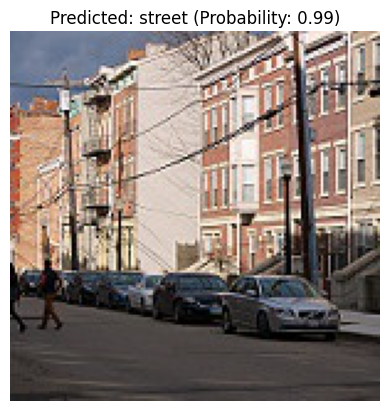

In [40]:
random_image_filename = random.choice(image_filenames)

image_path = os.path.join(DATA_PATH+'\seg_pred', random_image_filename)

image = Image.open(image_path)

input_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)
    probabilities = nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

plt.imshow(image)
plt.title(f"Predicted: {class_labels[predicted_class]} (Probability: {probabilities[0][predicted_class].item():.2f})")
plt.axis('off')
plt.show()